# Import 

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'royal-hexa-in-house'

from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project=project_id)

# EDA 

In [2]:
query = """ 
select distinct user_pseudo_id, level, day from `royal-hexa-in-house.dung_dinner_flatten.level_end_day`
where level is not null and day is not null
and user_pseudo_id in 
(select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.first_open` where event_date between '2025-03-15' and '2025-03-30')
"""
end_day = client.query(query).to_dataframe()
end_day

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_pseudo_id,level,day
0,e7f3b4af8adf777af1d13c944dde4583,29,3
1,5d8323874cb99631c404cc1b91a68fa0,58,30
2,becb6286dcd45de28d7afe230308cf6e,28,14
3,887ff26e0fa53d65b66952c67bc4d2ca,29,25
4,f4b88552de29a2877b842f83908c4150,41,30
...,...,...,...
194741,f8d0f86fd46a725ad496a6790b476a56,25,13
194742,6462db42385ad92020cd09b07333f03c,25,6
194743,84f80405307f483aff18ab7b88be4ebb,25,7
194744,387d1805c0c70f20986adbb4624c36e7,25,1


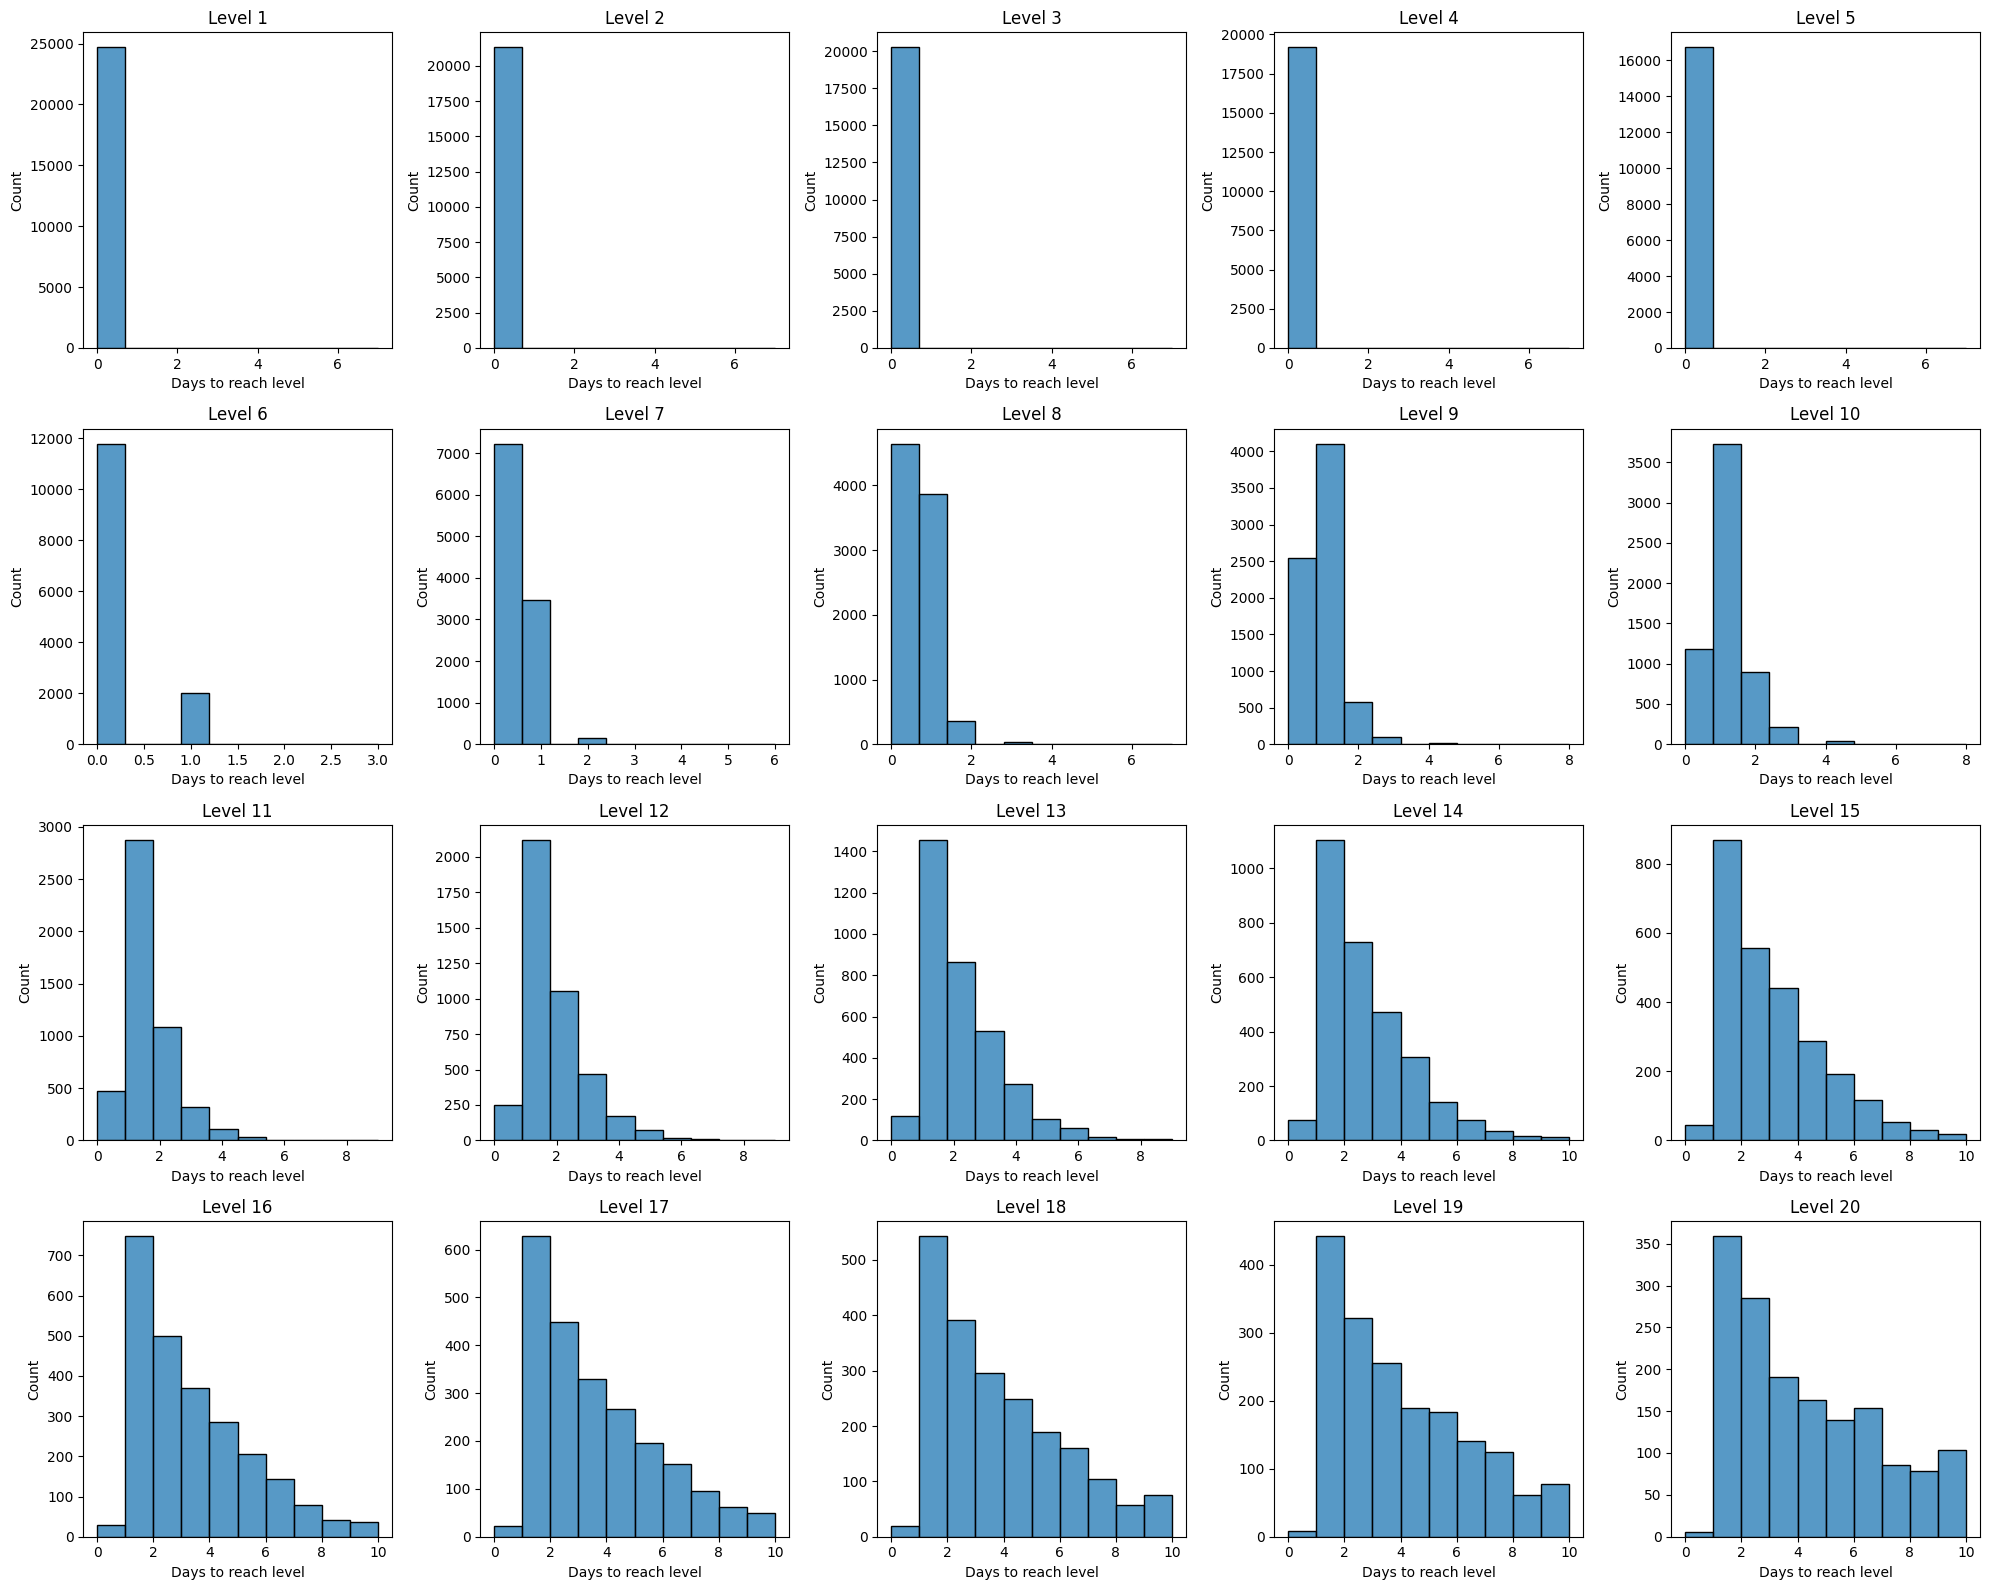

In [37]:
# Create a figure with 20 subplots arranged in 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

# Get unique levels up to 20 and filter for days <= 10
filtered_data = end_day[end_day['day'] <= 10]
levels = sorted(filtered_data['level'].unique())[:20]  # Take first 20 levels

# Create histogram for each level
for i, level in enumerate(levels):
    level_data = filtered_data[filtered_data['level'] == level]['day']
    
    sns.histplot(data=level_data, bins=10, ax=axes[i])
    axes[i].set_title(f'Level {level}')
    axes[i].set_xlabel('Days to reach level')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Nhận thấy rằng đa phần user đều có thể hoàn thành level 6 trong d0.
Vì vậy ta có thể lấy mốc dễ nhất để segment là d0: 
- Nhóm 1: User hoàn thành được level 6
- Nhóm 2: User không hoàn thành được level 6

In [38]:
# Số lượng 2 nhóm 
# Count users who completed level 6 on day 0 vs after day 0
level_6_users = end_day[end_day['level'] == 6].groupby('day')['user_pseudo_id'].nunique()

print("Users completing level 6:")
print(f"On day 0: {level_6_users.get(0, 0):,}")
print(f"After day 0: {level_6_users[level_6_users.index > 0].sum():,}")

Users completing level 6:
On day 0: 11,783
After day 0: 2,052


Chênh lệch 2 nhóm quá lớn, việc segment để đối xử với 10% user cảm thấy không hiệu quả

Tiếp theo ta sẽ lấy ra số lượng user chỉ hoàn thành đúng level đó trong d0 sau đó dừng lại(ví dụ có event end level 6 tại d0 thì phải ko có event end level 7 tại d0 thì mới được tính)

In [39]:
# Get users who completed each level exactly on day 0 and didn't progress further that day
level_counts = []
level_labels = []


# Handle levels 6-8 individually
for level in range(6, 9):
    # Get users who completed this level on day 0
    users_at_level = end_day[
        (end_day['level'] == level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Exclude users who completed higher levels on day 0
    users_at_higher_levels = end_day[
        (end_day['level'] > level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Get users who ONLY completed this level on day 0
    final_users = set(users_at_level) - set(users_at_higher_levels)
    
    level_counts.append(len(final_users))
    level_labels.append(level)

# Handle level 9 and above as one group
users_at_high_level = end_day[
    (end_day['level'] >= 9) & 
    (end_day['day'] == 0)
]['user_pseudo_id'].unique()

level_counts.append(len(users_at_high_level))
level_labels.append('>=9')

# Create a summary dataframe
summary_df = pd.DataFrame({
    'level': level_labels,
    'users_completed_d0': level_counts
})

print("Number of users who completed each level on day 0 and stopped:")
display(summary_df)

Number of users who completed each level on day 0 and stopped:


,level,users_completed_d0
0,6,4569
1,7,2582
2,8,2109
3,>=9,2562


 Được 4 nhóm: 
- Hoàn thành level 6 trong d0 (xong stop) 
- Hoàn thành level 7 trong d0 (xong stop) 
- Hoàn thành level 8 trong d0 (xong stop) 
- Hoàn thành > level 9 trong d0 (xong stop hoặc là ko) 






In [41]:
# Get users who completed each level exactly on day 0 and didn't progress further that day
# Initialize series to store user IDs for each group
users_level_6 = pd.Series(dtype='object') 
users_level_7 = pd.Series(dtype='object')
users_level_8 = pd.Series(dtype='object')
users_level_9_plus = pd.Series(dtype='object')

# Handle levels 6-8 individually
for level in range(6, 9):
    # Get users who completed this level on day 0
    users_at_level = end_day[
        (end_day['level'] == level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Exclude users who completed higher levels on day 0
    users_at_higher_levels = end_day[
        (end_day['level'] > level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Get users who ONLY completed this level on day 0
    final_users = set(users_at_level) - set(users_at_higher_levels)
    
    # Store users in appropriate series
    if level == 6:
        users_level_6 = pd.Series(list(final_users))
    elif level == 7:
        users_level_7 = pd.Series(list(final_users))
    elif level == 8:
        users_level_8 = pd.Series(list(final_users))

# Handle level 9 and above as one group
users_level_9_plus = pd.Series(end_day[
    (end_day['level'] >= 9) & 
    (end_day['day'] == 0)
]['user_pseudo_id'].unique())

print("Number of users in each group:")
print(f"Level 6: {len(users_level_6)}")
print(f"Level 7: {len(users_level_7)}")
print(f"Level 8: {len(users_level_8)}")
print(f"Level >=9: {len(users_level_9_plus)}")

Number of users in each group:
Level 6: 4569
Level 7: 2582
Level 8: 2109
Level >=9: 2562


### Compare 4 segment 

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


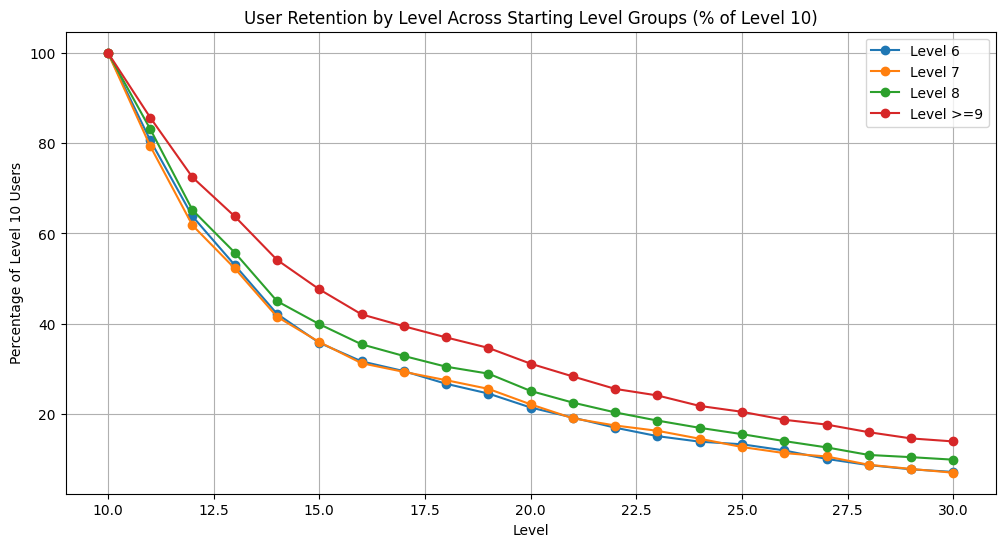

In [42]:
query = f"""
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_6)}) THEN user_pseudo_id END) as users_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_7)}) THEN user_pseudo_id END) as users_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_8)}) THEN user_pseudo_id END) as users_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_9_plus)}) THEN user_pseudo_id END) as users_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
WHERE level between 10 and 30 
GROUP BY level
ORDER BY level;
"""

drop_by_level = client.query(query).to_dataframe()

# Calculate percentages relative to level 10 for each user group
level10_users_6 = drop_by_level[drop_by_level['level']==10]['users_level_6'].values[0]
level10_users_7 = drop_by_level[drop_by_level['level']==10]['users_level_7'].values[0]
level10_users_8 = drop_by_level[drop_by_level['level']==10]['users_level_8'].values[0]
level10_users_9_plus = drop_by_level[drop_by_level['level']==10]['users_level_9_plus'].values[0]

drop_by_level['pct_level_6'] = drop_by_level['users_level_6'] / level10_users_6 * 100
drop_by_level['pct_level_7'] = drop_by_level['users_level_7'] / level10_users_7 * 100
drop_by_level['pct_level_8'] = drop_by_level['users_level_8'] / level10_users_8 * 100
drop_by_level['pct_level_9_plus'] = drop_by_level['users_level_9_plus'] / level10_users_9_plus * 100

# Define colors for user groups
level_colors = {
    'Level 6': '#1f77b4',    # Blue
    'Level 7': '#ff7f0e',    # Orange
    'Level 8': '#2ca02c',    # Green
    'Level >=9': '#d62728'   # Red
}

# Plot percentages for levels 10-30
plt.figure(figsize=(12, 6))
plt.plot(drop_by_level['level'], drop_by_level['pct_level_6'], 
         marker='o', label='Level 6', color=level_colors['Level 6'])
plt.plot(drop_by_level['level'], drop_by_level['pct_level_7'],
         marker='o', label='Level 7', color=level_colors['Level 7'])
plt.plot(drop_by_level['level'], drop_by_level['pct_level_8'],
         marker='o', label='Level 8', color=level_colors['Level 8'])
plt.plot(drop_by_level['level'], drop_by_level['pct_level_9_plus'],
         marker='o', label='Level >=9', color=level_colors['Level >=9'])

plt.xlabel('Level')
plt.ylabel('Percentage of Level 10 Users')
plt.title('User Retention by Level Across Starting Level Groups (% of Level 10)')
plt.legend()
plt.grid(True)
plt.show()

Cái này đương nhiên là như này rồi

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


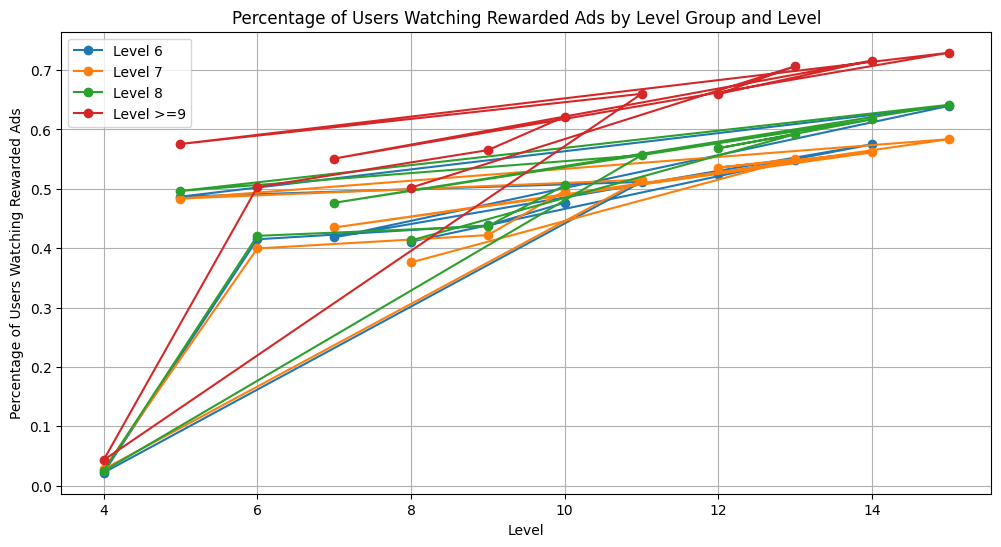

In [ ]:
# Ad rw 
query = f"""
WITH START AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN user_pseudo_id END) as start_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN user_pseudo_id END) as start_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN user_pseudo_id END) as start_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN user_pseudo_id END) as start_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
GROUP BY level
ORDER BY level
),
AD AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN user_pseudo_id END) as user_rewarded_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN user_pseudo_id END) as user_rewarded_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN user_pseudo_id END) as user_rewarded_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN user_pseudo_id END) as user_rewarded_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.af_rewarded`
GROUP BY level
ORDER BY level
)
SELECT s.level, 
       SAFE_DIVIDE(a.user_rewarded_level_6, s.start_level_6) as pct_user_rewarded_level_6,
       SAFE_DIVIDE(a.user_rewarded_level_7, s.start_level_7) as pct_user_rewarded_level_7,
       SAFE_DIVIDE(a.user_rewarded_level_8, s.start_level_8) as pct_user_rewarded_level_8,
       SAFE_DIVIDE(a.user_rewarded_level_9_plus, s.start_level_9_plus) as pct_user_rewarded_level_9_plus
FROM START s
JOIN AD a
ON s.level = a.level
where s.level between 4 and 15
"""


c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


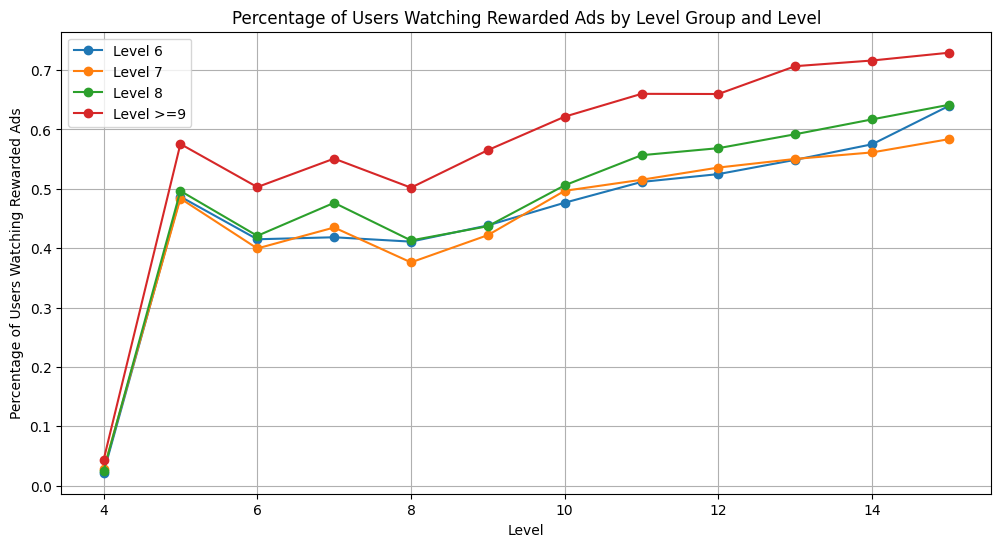

In [50]:
user_rewarded_by_level = client.query(query).to_dataframe()
user_rewarded_by_level.sort_values(by='level', inplace=True)

plt.figure(figsize=(12, 6))

plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_6, marker='o', label='Level 6', color=level_colors['Level 6'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_7, marker='o', label='Level 7', color=level_colors['Level 7'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_8, marker='o', label='Level 8', color=level_colors['Level 8'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_9_plus, marker='o', label='Level >=9', color=level_colors['Level >=9'])
                
plt.xlabel('Level')
plt.ylabel('Percentage of Users Watching Rewarded Ads')
plt.title('Percentage of Users Watching Rewarded Ads by Level Group and Level')
plt.legend()
plt.grid(True)
plt.show()

User càng chơi nhiều level trong d0 thì là user yêu thích game, xem nhiều ads

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


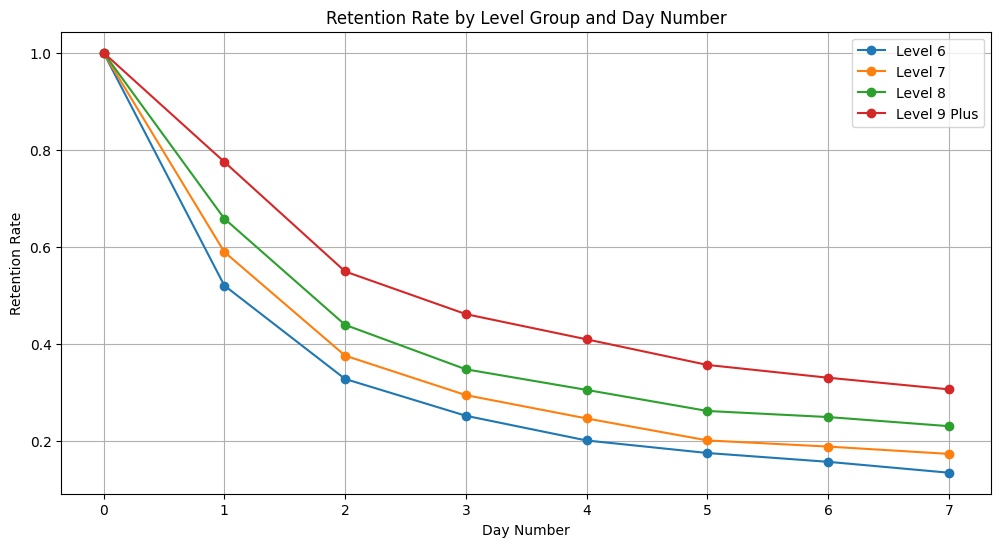

In [51]:
query = """ 
WITH user_groups AS (
  SELECT 
    user_pseudo_id,
    CASE 
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN 'level_6'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN 'level_7'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN 'level_8'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN 'level_9_plus'
    END as user_group
  FROM `royal-hexa-in-house.dung_dinner_flatten.first_open`
  GROUP BY 1
),
first_open_dates AS (
  SELECT 
    user_pseudo_id,
    MIN(event_date) as first_open_date
  FROM `royal-hexa-in-house.dung_dinner_flatten.first_open`
  WHERE user_pseudo_id IN (SELECT user_pseudo_id FROM user_groups WHERE user_group IS NOT NULL)
  GROUP BY 1
),
engagement AS (
  SELECT DISTINCT user_pseudo_id, event_date 
  FROM `royal-hexa-in-house.dung_dinner_flatten.user_engagement`
),
retention_data AS (
  SELECT
    g.user_group,
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    DATE_DIFF(e.event_date, f.first_open_date, DAY) as day_number
  FROM first_open_dates f
  JOIN user_groups g ON f.user_pseudo_id = g.user_pseudo_id
  LEFT JOIN engagement e ON f.user_pseudo_id = e.user_pseudo_id
  WHERE DATE_DIFF(e.event_date, f.first_open_date, DAY) BETWEEN 0 AND 7
)
SELECT
  user_group,
  day_number,
  COUNT(DISTINCT user_pseudo_id) as retained_users
FROM retention_data
GROUP BY 1, 2
ORDER BY 1, 2
"""

retention_by_group = client.query(query).to_dataframe()

# Calculate retention rates for each group
groups = ['level_6', 'level_7', 'level_8', 'level_9_plus']
retention_rates = pd.DataFrame()

for group in groups:
    group_data = retention_by_group[retention_by_group['user_group'] == group].copy()
    day0_users = group_data.loc[group_data['day_number']==0, 'retained_users'].iloc[0]
    group_data['retention_rate'] = group_data['retained_users'] / day0_users
    retention_rates = pd.concat([retention_rates, group_data])

# Plot retention rates
plt.figure(figsize=(12,6))
for group in groups:
    group_data = retention_rates[retention_rates['user_group'] == group]
    plt.plot(group_data['day_number'], group_data['retention_rate'], 
             label=group.replace('_', ' ').title(), 
             marker='o',
             color=level_colors['Level ' + group.split('_')[-1].replace('plus', '>=9')])

plt.xlabel('Day Number')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Level Group and Day Number')
plt.grid(True)
plt.legend()
plt.show()

User càng chơi nhiều level trong d0 thì là user yêu thích game, ở lại game tốt theo từng ngày 


c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


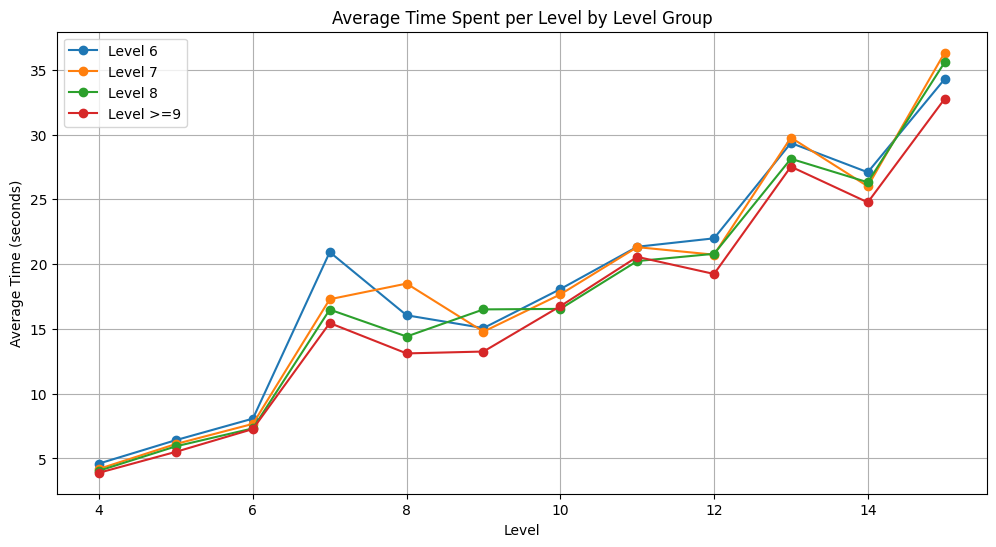

In [54]:
# Time per level
query = f"""
WITH START AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN user_pseudo_id END) as start_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN user_pseudo_id END) as start_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN user_pseudo_id END) as start_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN user_pseudo_id END) as start_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
GROUP BY level
ORDER BY level
),
TIME_LEVEL AS (
SELECT
    level,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN time_minute END) as avg_time_level_6,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN time_minute END) as avg_time_level_7,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN time_minute END) as avg_time_level_8,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN time_minute END) as avg_time_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.level_time`
GROUP BY level
ORDER BY level
)
SELECT s.level,
       t.avg_time_level_6,
       t.avg_time_level_7, 
       t.avg_time_level_8,
       t.avg_time_level_9_plus
FROM START s
JOIN TIME_LEVEL t
ON s.level = t.level
WHERE s.level between 4 and 15
"""
time_per_level = client.query(query).to_dataframe()
time_per_level.sort_values(by='level', inplace=True)

plt.figure(figsize=(12, 6))

plt.plot(time_per_level.level, time_per_level.avg_time_level_6, marker='o', label='Level 6', color=level_colors['Level 6'])
plt.plot(time_per_level.level, time_per_level.avg_time_level_7, marker='o', label='Level 7', color=level_colors['Level 7'])
plt.plot(time_per_level.level, time_per_level.avg_time_level_8, marker='o', label='Level 8', color=level_colors['Level 8'])
plt.plot(time_per_level.level, time_per_level.avg_time_level_9_plus, marker='o', label='Level >=9', color=level_colors['Level >=9'])
                
plt.xlabel('Level')
plt.ylabel('Average Time (seconds)')
plt.title('Average Time Spent per Level by Level Group')
plt.legend()
plt.grid(True)
plt.show()

Level 9 time chơi ngắn hơn user level 8 và ngắn hơn 6 + 7. Tệp user hoàn thành level 6 và level 7 khá giống nhau trong nhiều trường hợp

# Use Kmeans for  days to end level 6, 7, 8, 9

segment point: level 9

In [5]:
query = """ 
select distinct user_pseudo_id, level, day from `royal-hexa-in-house.dung_dinner_flatten.level_end_day`
where level is not null and day is not null
and user_pseudo_id in 
(select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.first_open` where event_date between '2025-03-15' and '2025-04-15') 
and user_pseudo_id in 
(select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.win_level` where level = 9)
"""
end_day = client.query(query).to_dataframe()
end_day

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_pseudo_id,level,day
0,a30d264758ef112d69145768621c178a,30,3
1,d12e40b61a34073e0e8b840d0d3931d8,33,4
2,e3b75ec482eb1e98bce5504ba3c93e27,37,12
3,2c5ed00b25382e63c86b6f079b696465,29,13
4,92a66d5664193c7e41c038e934fa5b94,30,15
...,...,...,...
202040,f12c71072b11ede8378c6d3aa6c379fa,28,1
202041,d6539c0525408e46616b929def22e1a1,28,1
202042,dadb761013a62ddbdd7ba0f56cd2faed,28,4
202043,dc33fb28e0592cdac97b1460fdcdee25,28,3


In [6]:
# Create a new dataframe with max days for each level per user
level_6_days = end_day[end_day['level'] == 6].groupby('user_pseudo_id')['day'].max().reset_index()
level_6_days.columns = ['user_pseudo_id', 'level_6']

level_7_days = end_day[end_day['level'] == 7].groupby('user_pseudo_id')['day'].max().reset_index()
level_7_days.columns = ['user_pseudo_id', 'level_7']

level_8_days = end_day[end_day['level'] == 8].groupby('user_pseudo_id')['day'].max().reset_index()
level_8_days.columns = ['user_pseudo_id', 'level_8']

level_9_days = end_day[end_day['level'] == 9].groupby('user_pseudo_id')['day'].max().reset_index()
level_9_days.columns = ['user_pseudo_id', 'level_9']

# Merge all level dataframes
days_to_end = level_6_days.merge(level_7_days, on='user_pseudo_id', how='outer')\
                         .merge(level_8_days, on='user_pseudo_id', how='outer')\
                         .merge(level_9_days, on='user_pseudo_id', how='outer')

days_to_end

,user_pseudo_id,level_6,level_7,level_8,level_9
0,0001e2b30917185b1734ee1635423c43,0,0,1,1
1,0001edaa69164ee1c9ea34f25878cd88,0,0,0,1
2,000832da752894f9bb3132926719aa22,0,0,0,0
3,000d49e54247e2f43851459c832638c2,0,0,0,1
4,0017016ff42eb00776bda874fa81b3eb,0,1,1,1
...,...,...,...,...,...
13183,2e31da376260a6f87a4846db67825ac5,<NA>,<NA>,<NA>,1
13184,59fe390efcca8226d981fb02c8a24cae,<NA>,<NA>,<NA>,1
13185,5d24a7a6d9469b5d34ccebf76957819b,<NA>,<NA>,<NA>,0
13186,74270c28bbb38b38edf62cf20ec12b95,<NA>,<NA>,<NA>,1


In [9]:
# Drop rows with any null values
days_to_end = days_to_end.dropna()

days_to_end

,user_pseudo_id,level_6,level_7,level_8,level_9
0,0001e2b30917185b1734ee1635423c43,0,0,1,1
1,0001edaa69164ee1c9ea34f25878cd88,0,0,0,1
2,000832da752894f9bb3132926719aa22,0,0,0,0
3,000d49e54247e2f43851459c832638c2,0,0,0,1
4,0017016ff42eb00776bda874fa81b3eb,0,1,1,1
...,...,...,...,...,...
13082,ffec61eadf58464d9760ff4fda49f113,0,0,0,1
13083,ffee3a9b862e50c34f9a00faee723c7f,1,1,1,1
13084,ffeea9409545f6a1cb4e7411c47bb7f0,0,1,2,2
13085,fff3ed85b0d283478a0ad8a443cffeef,0,0,1,1


In [10]:
days_to_end_k = days_to_end[['level_6', 'level_7', 'level_8', 'level_9']]

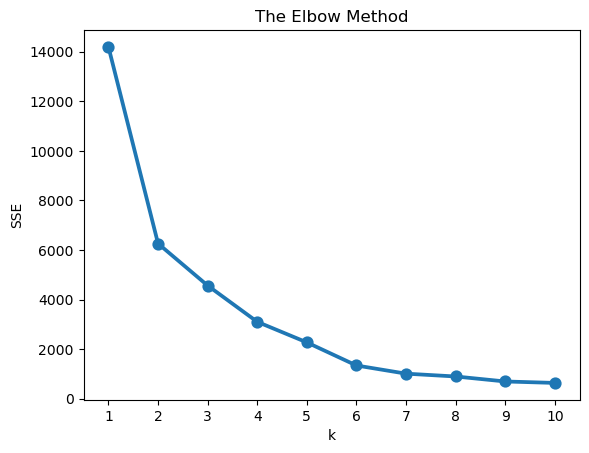

In [11]:
# Đưa vào KMeans 
#Đưa dữ liệu vào Kmean
from sklearn.preprocessing import MinMaxScaler

# Chọn số cụm bằng Elbow
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(days_to_end_k)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

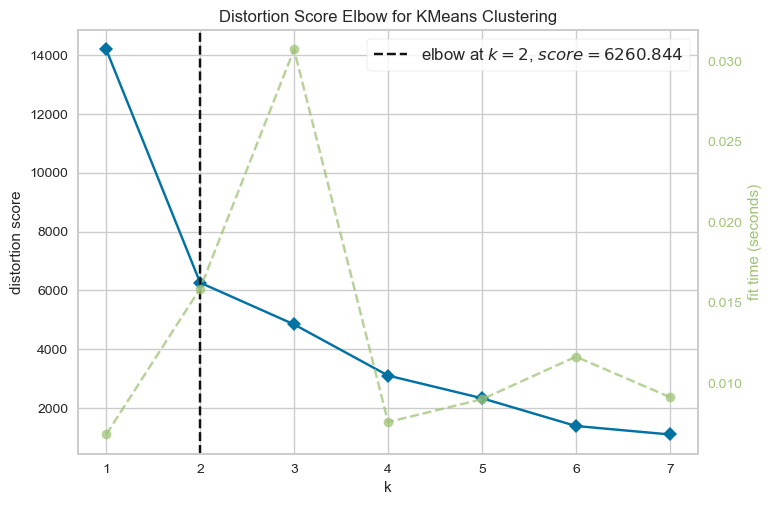

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Standardize the features
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,8), locate_elbow=True)

visualizer.fit(days_to_end_k)
visualizer.show()

In [13]:
model = KMeans(n_clusters=2, random_state = 42)
model.fit(days_to_end_k)

KMeans(n_clusters=2, random_state=42)

In [17]:
days_to_end['cluster'] = model.labels_
days_to_end

,user_pseudo_id,level_6,level_7,level_8,level_9,cluster
0,0001e2b30917185b1734ee1635423c43,0,0,1,1,1
1,0001edaa69164ee1c9ea34f25878cd88,0,0,0,1,0
2,000832da752894f9bb3132926719aa22,0,0,0,0,0
3,000d49e54247e2f43851459c832638c2,0,0,0,1,0
4,0017016ff42eb00776bda874fa81b3eb,0,1,1,1,1
...,...,...,...,...,...,...
13082,ffec61eadf58464d9760ff4fda49f113,0,0,0,1,0
13083,ffee3a9b862e50c34f9a00faee723c7f,1,1,1,1,1
13084,ffeea9409545f6a1cb4e7411c47bb7f0,0,1,2,2,1
13085,fff3ed85b0d283478a0ad8a443cffeef,0,0,1,1,1


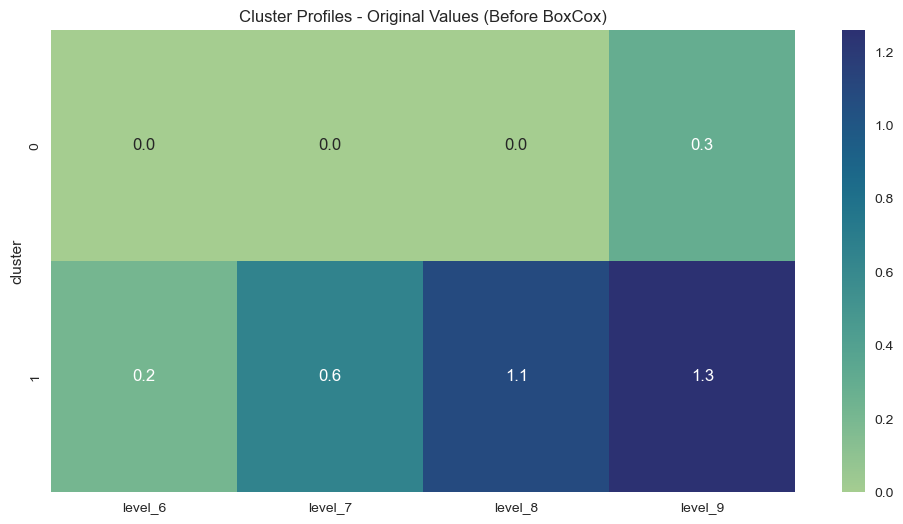

In [18]:
# Get feature columns for analysis - using original data before boxcox transformation
feature_cols = ['level_6', 'level_7', 'level_8', 'level_9'] 
tt = days_to_end_k[feature_cols + ['cluster']]

# Calculate mean values for each cluster
cluster_profiles = tt.groupby('cluster')[feature_cols].mean()

# Convert to numeric type explicitly
cluster_profiles = cluster_profiles.astype(float)

# Visualize cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, annot=True, cmap='crest', fmt='.1f')
plt.title('Cluster Profiles - Original Values (Before BoxCox)')
plt.show()

In [19]:
# So user mỗi nhóm
days_to_end.groupby('cluster')['user_pseudo_id'].nunique()

cluster
0    7820
1    5092
Name: user_pseudo_id, dtype: int64

Giải thích 2 nhóm:
- Nhóm 0: Là nhóm user chơi nhiều level, chủ yếu đã hoàn thành 6 7 8  trong d0,  tốn 0 -> 1 ngày để hoàn  thành level 9 (đa phần là 0 ngày)
- Nhóm 1: Là nhóm user khá hỗn tạp, đa phần tốn 0 đến 1 ngày để hoàn thành level 6 và 7, tốn > 1 ngày để hoàn thành level 8 và 9

2 nhóm phân bổ khá đều => Good

### Compare 2 group 

In [20]:
# Get user_pseudo_ids for each cluster
cluster0_users = tuple(days_to_end[days_to_end['cluster']==0]['user_pseudo_id'].unique())
cluster1_users = tuple(days_to_end[days_to_end['cluster']==1]['user_pseudo_id'].unique()) 

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


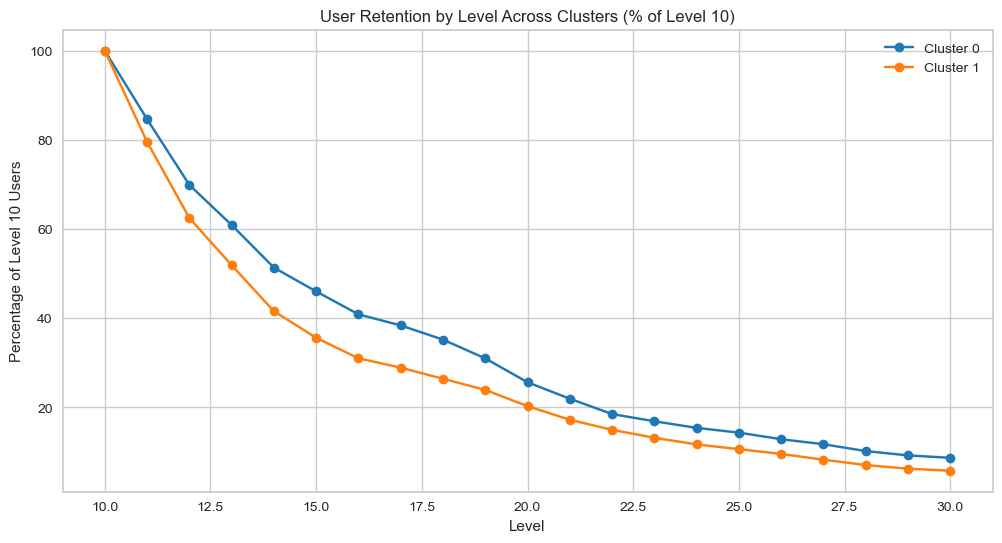

In [21]:
query = f"""
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster0_users)}) THEN user_pseudo_id END) as cluster0_users,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster1_users)}) THEN user_pseudo_id END) as cluster1_users
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
WHERE level between 10 and 30 
GROUP BY level
ORDER BY level;
"""

drop_by_level = client.query(query).to_dataframe()

# Calculate percentages relative to level 10 for each cluster
level10_cluster0 = drop_by_level[drop_by_level['level']==10]['cluster0_users'].values[0]
level10_cluster1 = drop_by_level[drop_by_level['level']==10]['cluster1_users'].values[0]

drop_by_level['pct_cluster0'] = drop_by_level['cluster0_users'] / level10_cluster0 * 100
drop_by_level['pct_cluster1'] = drop_by_level['cluster1_users'] / level10_cluster1 * 100

# Define colors for clusters
cluster_colors = {
    'Cluster 0': '#1f77b4',    # Blue
    'Cluster 1': '#ff7f0e',    # Orange
}

# Plot percentages for levels 10-30
plt.figure(figsize=(12, 6))
plt.plot(drop_by_level['level'], drop_by_level['pct_cluster0'], 
         marker='o', label='Cluster 0', color=cluster_colors['Cluster 0'])
plt.plot(drop_by_level['level'], drop_by_level['pct_cluster1'],
         marker='o', label='Cluster 1', color=cluster_colors['Cluster 1'])

plt.xlabel('Level')
plt.ylabel('Percentage of Level 10 Users')
plt.title('User Retention by Level Across Clusters (% of Level 10)')
plt.legend()
plt.grid(True)
plt.show()

Đương nhiên là cluster 0 sẽ ở lại tốt hơn qua từng level 

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


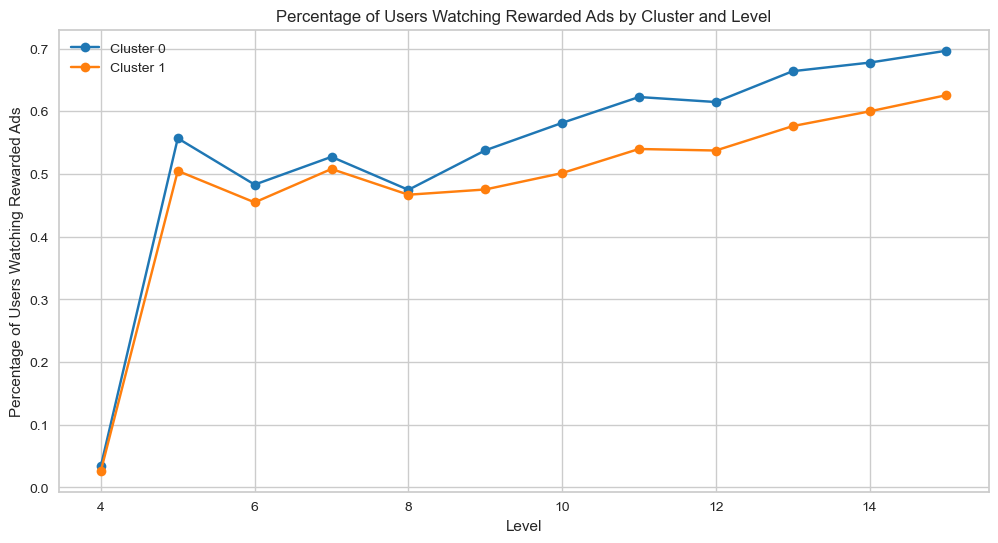

In [23]:
# Ad rw 
query = f"""
WITH START AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster0_users)}) THEN user_pseudo_id END) as start_cluster0,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster1_users)}) THEN user_pseudo_id END) as start_cluster1
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
GROUP BY level
ORDER BY level
),
AD AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster0_users)}) THEN user_pseudo_id END) as user_rewarded_cluster0,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster1_users)}) THEN user_pseudo_id END) as user_rewarded_cluster1
FROM
    `royal-hexa-in-house.dung_dinner_flatten.af_rewarded`
GROUP BY level
ORDER BY level
)
SELECT s.level, 
       SAFE_DIVIDE(a.user_rewarded_cluster0, s.start_cluster0) as pct_user_rewarded_cluster0,
       SAFE_DIVIDE(a.user_rewarded_cluster1, s.start_cluster1) as pct_user_rewarded_cluster1
FROM START s
JOIN AD a
ON s.level = a.level
where s.level between 4 and 15
"""
user_rewarded_by_level = client.query(query).to_dataframe()
user_rewarded_by_level.sort_values(by='level', inplace=True)

plt.figure(figsize=(12, 6))

plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_cluster0, 
         marker='o', label='Cluster 0', color=cluster_colors['Cluster 0'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_cluster1, 
         marker='o', label='Cluster 1', color=cluster_colors['Cluster 1'])
                
plt.xlabel('Level')
plt.ylabel('Percentage of Users Watching Rewarded Ads')
plt.title('Percentage of Users Watching Rewarded Ads by Cluster and Level')
plt.legend()
plt.grid(True)
plt.show()

Nhóm 0 chịu khó xem ads hơn, cũng vì lí do đó mà chơi nhanh hơn (cơ chế game này có năng lượng, có thể nhóm này thích game nên chịu khó ad rw để tích năng lượng)

In [28]:
query = """ 
WITH user_groups AS (
  SELECT 
    user_pseudo_id,
    CASE 
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in cluster0_users]) + """]) THEN 'cluster0_users'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in cluster1_users]) + """]) THEN 'cluster1_users'
    END as user_group
  FROM `royal-hexa-in-house.dung_dinner_flatten.first_open`
  GROUP BY 1
),
first_open_dates AS (
  SELECT 
    user_pseudo_id,
    MIN(event_date) as first_open_date
  FROM `royal-hexa-in-house.dung_dinner_flatten.first_open`
  WHERE user_pseudo_id IN (SELECT user_pseudo_id FROM user_groups WHERE user_group IS NOT NULL)
  GROUP BY 1
),
engagement AS (
  SELECT DISTINCT user_pseudo_id, event_date 
  FROM `royal-hexa-in-house.dung_dinner_flatten.user_engagement`
),
retention_data AS (
  SELECT
    g.user_group,
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    DATE_DIFF(e.event_date, f.first_open_date, DAY) as day_number
  FROM first_open_dates f
  JOIN user_groups g ON f.user_pseudo_id = g.user_pseudo_id
  LEFT JOIN engagement e ON f.user_pseudo_id = e.user_pseudo_id
  WHERE DATE_DIFF(e.event_date, f.first_open_date, DAY) BETWEEN 0 AND 7
)
SELECT
  user_group,
  day_number,
  COUNT(DISTINCT user_pseudo_id) as retained_users
FROM retention_data
GROUP BY 1, 2
ORDER BY 1, 2
"""

retention_by_group = client.query(query).to_dataframe()
retention_by_group

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_group,day_number,retained_users
0,cluster0_users,0,7641
1,cluster0_users,1,6065
2,cluster0_users,2,4511
3,cluster0_users,3,3733
4,cluster0_users,4,3263
5,cluster0_users,5,2778
6,cluster0_users,6,2560
7,cluster0_users,7,2362
8,cluster1_users,0,4969
9,cluster1_users,1,3940


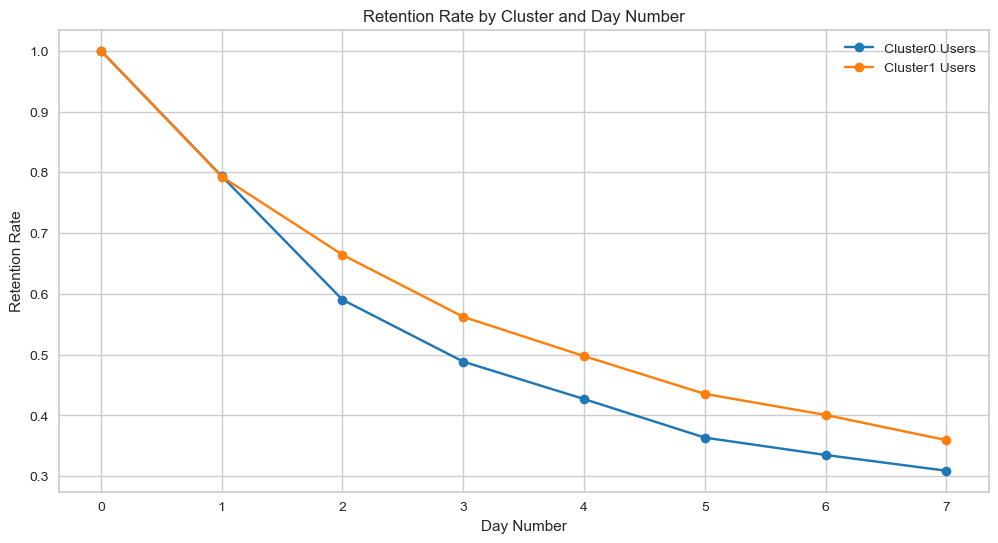

In [30]:


# Calculate retention rates for each group
groups = ['cluster0_users', 'cluster1_users']
retention_rates = pd.DataFrame()

for group in groups:
    group_data = retention_by_group[retention_by_group['user_group'] == group].copy()
    day0_users = group_data.loc[group_data['day_number']==0, 'retained_users'].iloc[0]
    group_data['retention_rate'] = group_data['retained_users'] / day0_users
    retention_rates = pd.concat([retention_rates, group_data])

# Plot retention rates
plt.figure(figsize=(12,6))
for group in groups:
    group_data = retention_rates[retention_rates['user_group'] == group]
    group_label = group.replace('_', ' ').title()
    plt.plot(group_data['day_number'], group_data['retention_rate'], 
             label=group_label,
             marker='o',
             color=cluster_colors[f'Cluster {group[7]}'])

plt.xlabel('Day Number')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Cluster and Day Number')
plt.grid(True)
plt.legend()
plt.show()

 Nhóm 0 đang bị drop cao hơn 

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


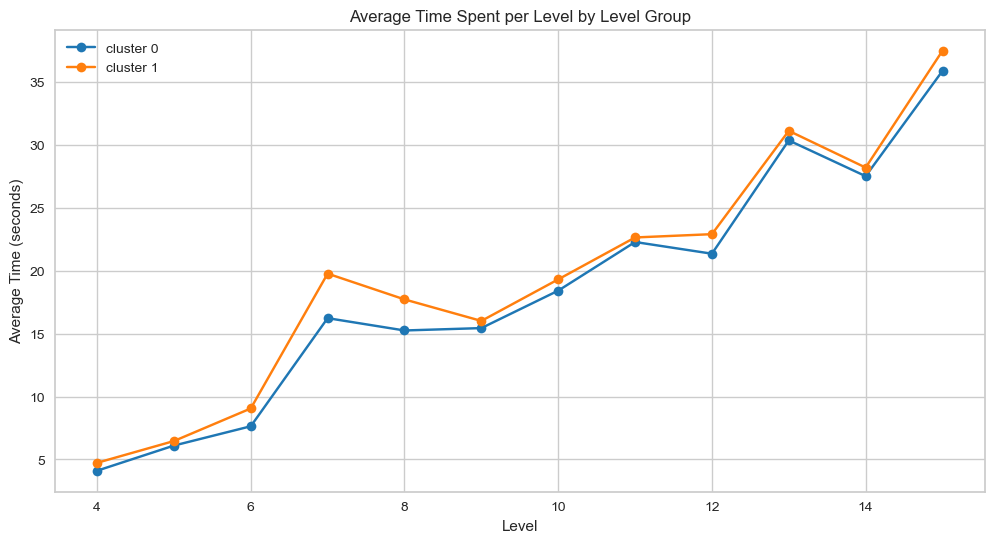

In [34]:
# Time per level
query = f"""
WITH START AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in cluster0_users]) + """]) THEN user_pseudo_id END) as cluster0_users,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in cluster1_users]) + """]) THEN user_pseudo_id END) as cluster1_users
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
GROUP BY level
ORDER BY level
),
TIME_LEVEL AS (
SELECT
    level,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in cluster0_users]) + """]) THEN time_minute END) as avg_time_cluster0,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in cluster1_users]) + """]) THEN time_minute END) as avg_time_cluster1
FROM
    `royal-hexa-in-house.dung_dinner_flatten.level_time`
GROUP BY level
ORDER BY level
)
SELECT s.level,
       t.avg_time_cluster0,
       t.avg_time_cluster1
FROM START s
JOIN TIME_LEVEL t
ON s.level = t.level
WHERE s.level between 4 and 15
"""
time_per_level = client.query(query).to_dataframe()
time_per_level.sort_values(by='level', inplace=True)

plt.figure(figsize=(12, 6))

plt.plot(time_per_level.level, time_per_level.avg_time_cluster0, marker='o', label='cluster 0', color=cluster_colors['Cluster 0'])
plt.plot(time_per_level.level, time_per_level.avg_time_cluster1, marker='o', label='cluster 1', color=cluster_colors['Cluster 1'])
                
plt.xlabel('Level')
plt.ylabel('Average Time (seconds)')
plt.title('Average Time Spent per Level by Level Group')
plt.legend()
plt.grid(True)
plt.show()

 Nhóm 1 chơi kém hơn và mất nhiều thời gian hơn qua từng level 

# segment by device (good, average, bad), country (good, average, bad), time_to_win_level_6, num_session_to_win_level_6, num_rw_to_win_level_6

Tại lần segment này:
- Chia device thành bad, good, average -> select distinct rồi nhờ chat gpt chia 
- Chia country thành bad, good, average -> tự đánh giá

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


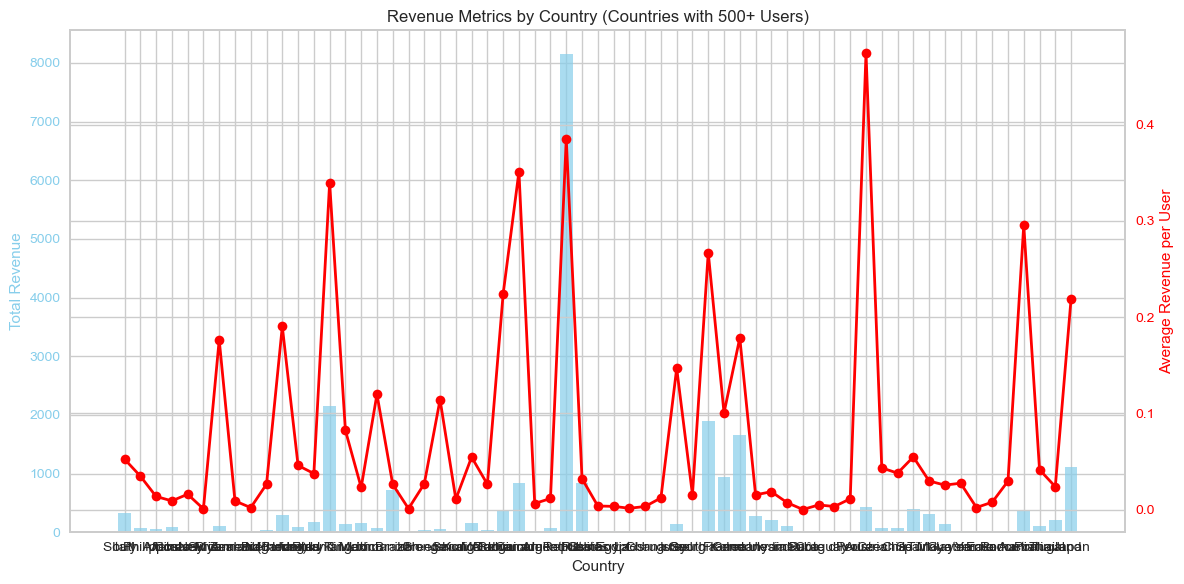

In [41]:
# Đánh giá country 
query = """
SELECT  
  country, 
  SUM(total_revenue) as total_revenue, 
  SUM(total_user) as total_user
FROM `royal-hexa-in-house.dung_dinner_dashboard.rev_iap_ads`
GROUP BY country
"""
country = client.query(query).to_dataframe()

# Filter for countries with 500+ users and calculate avg revenue per user
country = country[country.total_user >= 500].copy()
country['avg_rev_per_user'] = country.total_revenue / country.total_user

plt.figure(figsize=(12, 6))

# Create the bar plot for total revenue
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot total revenue as bars
ax1.bar(country.country, country.total_revenue, color='skyblue', alpha=0.7)
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Revenue', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plot average revenue per user as line
ax2.plot(country.country, country.avg_rev_per_user, color='red', linewidth=2, marker='o')
ax2.set_ylabel('Average Revenue per User', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Revenue Metrics by Country (Countries with 500+ Users)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/var/folders/63/ptp0pxpd2l9gff9vvxyg0fb00000gn/T/ipykernel_4475/3810180461.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(country.country, rotation=90)


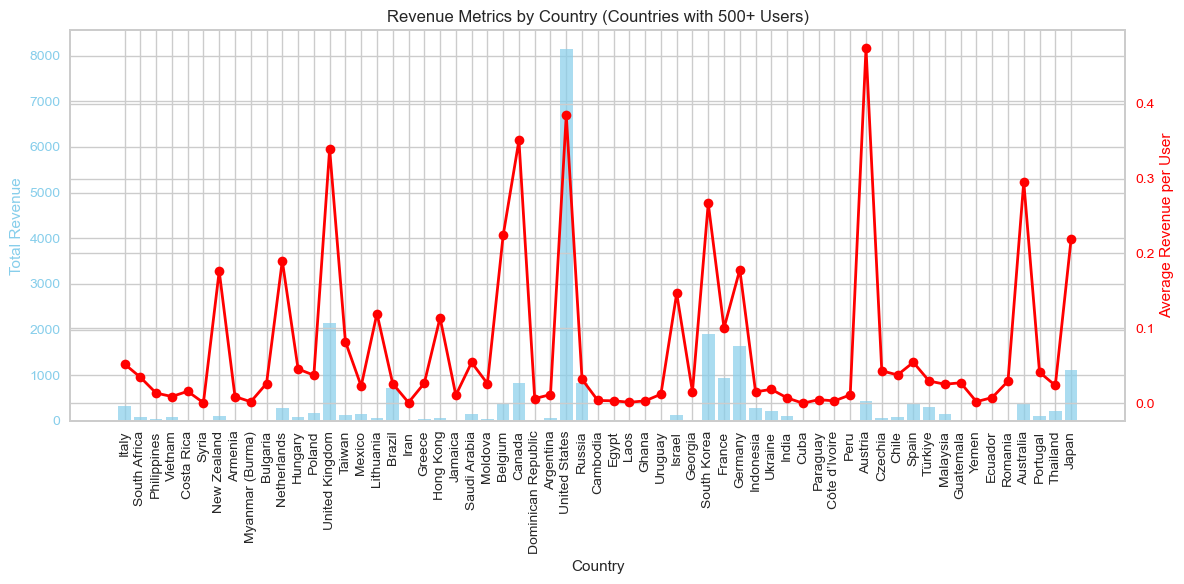

In [45]:
# Create the bar plot for total revenue
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot total revenue as bars
ax1.bar(country.country, country.total_revenue, color='skyblue', alpha=0.7)
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Revenue', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plot average revenue per user as line
ax2.plot(country.country, country.avg_rev_per_user, color='red', linewidth=2, marker='o')
ax2.set_ylabel('Average Revenue per User', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Revenue Metrics by Country (Countries with 500+ Users)')
ax1.set_xticklabels(country.country, rotation=90)
plt.tight_layout()
plt.show()

 => 3 cluster country:
- good country : United Kingdom, Canada, United States, Austria, 
- avg country: New Zealand, Netherlands, South Korea, Germany, Japan 
- bad country: Rest of world 

3 cluster device by system version
- Good: Android 13, Android 14, Android 14.0, Android 15, Android 16, Android 12, Android 12.0
- Average: Android 10, Android 11.0
- Bad: Android 6.0, Android 6.0.1, Android 7.0, Android 7.1.1, Android 7.1.2, Android 8, Android 8.1.0, Android 9.0

In [48]:
query = """
with user_finish_level_6 as (
  select 
    user_pseudo_id
  from `royal-hexa-in-house.dung_dinner_flatten.win_level`
  where level = 6 and user_pseudo_id in (select user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.first_open` where event_date between '2025-03-15' and '2025-04-15')
),
new_user as (
  select 
    user_pseudo_id,
    case 
      when country in ('United Kingdom', 'Canada', 'United States', 'Austria') then 'Good'
      when country in ('New Zealand', 'Netherlands', 'South Korea', 'Germany', 'Japan') then 'Average' 
      else 'Bad'
    end as country_cluster,
    case
      when operating_system_version in ('Android 13', 'Android 14', 'Android 14.0', 'Android 15', 'Android 16', 'Android 12', 'Android 12.0') then 'Good'
      when operating_system_version in ('Android 10', 'Android 11.0') then 'Average'
      else 'Bad'
    end as device_cluster,
    event_timestamp as first_open_time
  from `royal-hexa-in-house.dung_dinner_flatten.first_open`
),

time_to_level_6 as (
  select 
    user_pseudo_id,
    sum(time_minute) as time_to_reach_level_6
  from `royal-hexa-in-house.dung_dinner_flatten.level_time`
  where level <= 6
  group by user_pseudo_id
),
session_to_level_6 as (
  select 
    user_pseudo_id,
    ga_session_number as num_session_to_reach_level_6
  from `royal-hexa-in-house.dung_dinner_flatten.win_level`
  where level = 6
),

rewards_count as (
  select
    user_pseudo_id,
    count(*) as num_rw_to_win_level_6
  from `royal-hexa-in-house.dung_dinner_flatten.level_adreward`
  where level <= 6
  group by user_pseudo_id
)

select
  w.user_pseudo_id,
  n.device_cluster,
  n.country_cluster,
  t.time_to_reach_level_6,
  s.num_session_to_reach_level_6,
  coalesce(r.num_rw_to_win_level_6, 0) as num_rw_to_win_level_6
from `royal-hexa-in-house.dung_dinner_flatten.win_level` w
join new_user n on w.user_pseudo_id = n.user_pseudo_id
left join time_to_level_6 t on w.user_pseudo_id = t.user_pseudo_id
left join session_to_level_6 s on w.user_pseudo_id = s.user_pseudo_id
left join rewards_count r on w.user_pseudo_id = r.user_pseudo_id
where w.level = 6
""" 

df = client.query(query).to_dataframe()
df 

/Users/vudung/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_pseudo_id,device_cluster,country_cluster,time_to_reach_level_6,num_session_to_reach_level_6,num_rw_to_win_level_6
0,9c33152d26c6b39a0c47ad856d8984f3,Average,Bad,24.816667,2,13
1,38c719dc5a8d9a102406b0fd09e641d6,Bad,Bad,21.616667,1,13
2,77c6c83480bff1c22cc1fbc3f9c8a23d,Bad,Average,30.083333,2,19
3,3c210f3a449787fd4df0b80f94055132,Good,Bad,32.450000,1,18
4,628cb139077c00f290bbca4818f8305e,Good,Bad,28.233333,2,16
...,...,...,...,...,...,...
50725,4daf2c9d2edb0e798dc9ed038b566f6d,Good,Bad,27.666667,1,12
50726,116047b1cff6b9e3472d9fda0bba1bca,Good,Average,24.233333,1,12
50727,ad88146f7706ca3c98d3290ecf76812e,Good,Bad,18.233333,1,12
50728,78b862e10a3bfa9bb74f259edf9c7bb1,Good,Average,23.666667,1,12


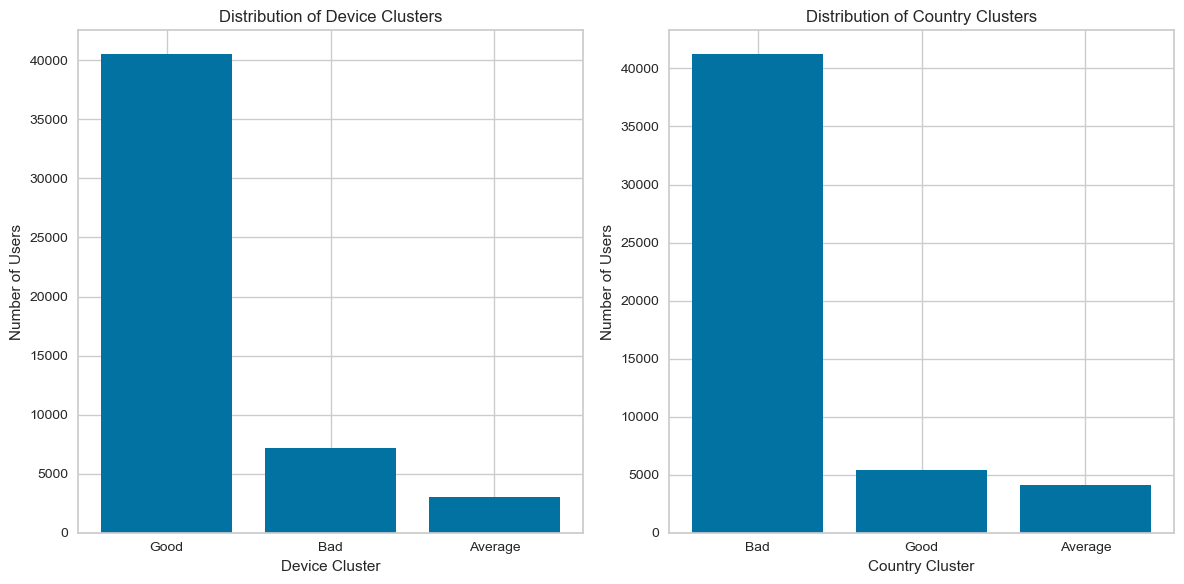

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Device cluster counts
device_counts = df['device_cluster'].value_counts()
ax1.bar(device_counts.index, device_counts.values)
ax1.set_title('Distribution of Device Clusters')
ax1.set_xlabel('Device Cluster')
ax1.set_ylabel('Number of Users')

# Country cluster counts 
country_counts = df['country_cluster'].value_counts()
ax2.bar(country_counts.index, country_counts.values)
ax2.set_title('Distribution of Country Clusters')
ax2.set_xlabel('Country Cluster')
ax2.set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

In [50]:
# Replace device_cluster values
df['device_cluster'] = df['device_cluster'].replace({'Good': 2, 'Average': 1, 'Bad': 0})

# Replace country_cluster values 
df['country_cluster'] = df['country_cluster'].replace({'Good': 2, 'Average': 1, 'Bad': 0})

df

,user_pseudo_id,device_cluster,country_cluster,time_to_reach_level_6,num_session_to_reach_level_6,num_rw_to_win_level_6
0,9c33152d26c6b39a0c47ad856d8984f3,1,0,24.816667,2,13
1,38c719dc5a8d9a102406b0fd09e641d6,0,0,21.616667,1,13
2,77c6c83480bff1c22cc1fbc3f9c8a23d,0,1,30.083333,2,19
3,3c210f3a449787fd4df0b80f94055132,2,0,32.450000,1,18
4,628cb139077c00f290bbca4818f8305e,2,0,28.233333,2,16
...,...,...,...,...,...,...
50725,4daf2c9d2edb0e798dc9ed038b566f6d,2,0,27.666667,1,12
50726,116047b1cff6b9e3472d9fda0bba1bca,2,1,24.233333,1,12
50727,ad88146f7706ca3c98d3290ecf76812e,2,0,18.233333,1,12
50728,78b862e10a3bfa9bb74f259edf9c7bb1,2,1,23.666667,1,12


## 1. Dùng Kmeans cho các feature ảnh hưởng đến chất lượng bên ngoài của người chơi: device, country 

In [51]:
df1 = df[['user_pseudo_id', 'device_cluster', 'country_cluster']]
df1 = df1.drop_duplicates()
df1 = df1.dropna()
df1 = df1.reset_index(drop=True)
df1



,user_pseudo_id,device_cluster,country_cluster
0,9c33152d26c6b39a0c47ad856d8984f3,1,0
1,38c719dc5a8d9a102406b0fd09e641d6,0,0
2,77c6c83480bff1c22cc1fbc3f9c8a23d,0,1
3,3c210f3a449787fd4df0b80f94055132,2,0
4,628cb139077c00f290bbca4818f8305e,2,0
...,...,...,...
48552,4daf2c9d2edb0e798dc9ed038b566f6d,2,0
48553,116047b1cff6b9e3472d9fda0bba1bca,2,1
48554,ad88146f7706ca3c98d3290ecf76812e,2,0
48555,78b862e10a3bfa9bb74f259edf9c7bb1,2,1


In [52]:
df1_k = df1[['device_cluster', 'country_cluster']]


/Users/vudung/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


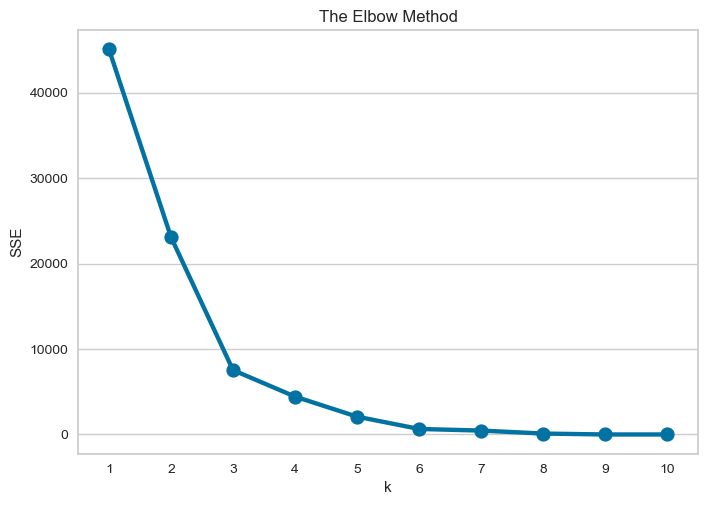

In [53]:
# Đưa vào KMeans 
#Đưa dữ liệu vào Kmean
from sklearn.preprocessing import MinMaxScaler

# Chọn số cụm bằng Elbow
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df1_k)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

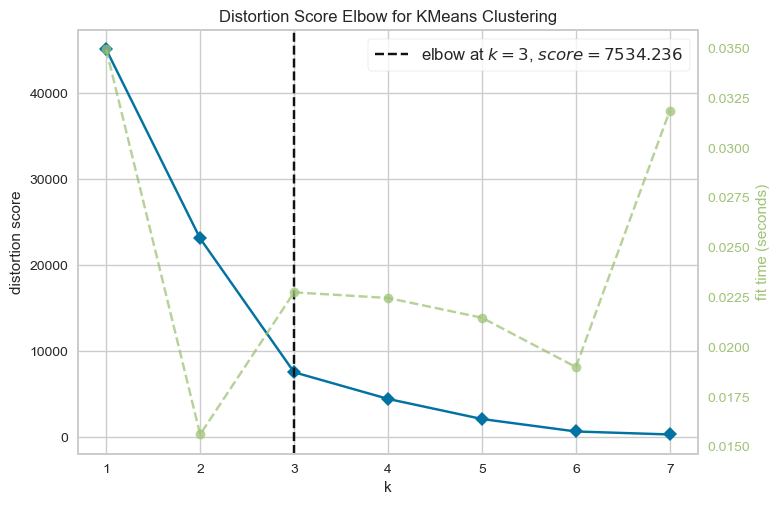

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Standardize the features
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,8), locate_elbow=True)

visualizer.fit(df1_k)
visualizer.show()

In [55]:
model = KMeans(n_clusters=3, random_state = 42)
model.fit(df1_k)

KMeans(n_clusters=3, random_state=42)

In [56]:
df1['cluster'] = model.labels_
df1 

,user_pseudo_id,device_cluster,country_cluster,cluster
0,9c33152d26c6b39a0c47ad856d8984f3,1,0,0
1,38c719dc5a8d9a102406b0fd09e641d6,0,0,1
2,77c6c83480bff1c22cc1fbc3f9c8a23d,0,1,1
3,3c210f3a449787fd4df0b80f94055132,2,0,0
4,628cb139077c00f290bbca4818f8305e,2,0,0
...,...,...,...,...
48552,4daf2c9d2edb0e798dc9ed038b566f6d,2,0,0
48553,116047b1cff6b9e3472d9fda0bba1bca,2,1,0
48554,ad88146f7706ca3c98d3290ecf76812e,2,0,0
48555,78b862e10a3bfa9bb74f259edf9c7bb1,2,1,0


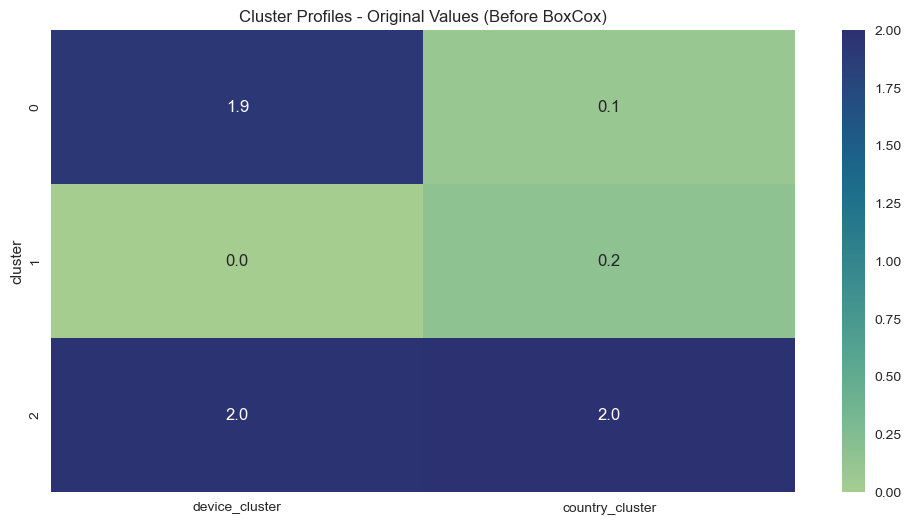

In [57]:
# Get feature columns for analysis - using original data before boxcox transformation
feature_cols = ['device_cluster', 'country_cluster']
tt = df1[feature_cols + ['cluster']]

# Calculate mean values for each cluster
cluster_profiles = tt.groupby('cluster')[feature_cols].mean()

# Convert to numeric type explicitly
cluster_profiles = cluster_profiles.astype(float)

# Visualize cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, annot=True, cmap='crest', fmt='.1f')
plt.title('Cluster Profiles - Original Values (Before BoxCox)')
plt.show()

In [58]:
# So user mỗi nhóm
df1.groupby('cluster')['user_pseudo_id'].nunique()

cluster
0    36900
1     6822
2     4835
Name: user_pseudo_id, dtype: int64

Giải thích:
- nhóm 0: device xịn, country đểu
- nhóm 1: device đểu, country đểu
- nhóm 2: device xịn, country xịn 

#### So sánh 3 nhóm 

In [59]:
# Get user_pseudo_ids for each cluster
cluster0_users = tuple(df1[df1['cluster']==0]['user_pseudo_id'].unique())
cluster1_users = tuple(df1[df1['cluster']==1]['user_pseudo_id'].unique()) 
cluster2_users = tuple(df1[df1['cluster']==2]['user_pseudo_id'].unique())

In [61]:
query = f"""
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster0_users)}) THEN user_pseudo_id END) as cluster0_users,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster1_users)}) THEN user_pseudo_id END) as cluster1_users,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(cluster2_users)}) THEN user_pseudo_id END) as cluster2_users
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
WHERE level between 10 and 30 
GROUP BY level
ORDER BY level;
"""

drop_by_level = client.query(query).to_dataframe()

# Calculate percentages relative to level 10 for each user group
level10_cluster0 = drop_by_level[drop_by_level['level']==10]['cluster0_users'].values[0]
level10_cluster1 = drop_by_level[drop_by_level['level']==10]['cluster1_users'].values[0]
level10_cluster2 = drop_by_level[drop_by_level['level']==10]['cluster2_users'].values[0]

drop_by_level['pct_cluster0'] = drop_by_level['cluster0_users'] / level10_cluster0 * 100
drop_by_level['pct_cluster1'] = drop_by_level['cluster1_users'] / level10_cluster1 * 100
drop_by_level['pct_cluster2'] = drop_by_level['cluster2_users'] / level10_cluster2 * 100

# Define colors for clusters
cluster_colors = {
    'Cluster 0': '#1f77b4',    # Blue
    'Cluster 1': '#ff7f0e',    # Orange  
    'Cluster 2': '#2ca02c'     # Green
}

# Plot percentages for levels 10-30
plt.figure(figsize=(12, 6))
plt.plot(drop_by_level['level'], drop_by_level['pct_cluster0'], 
         marker='o', label='Cluster 0 (Good device, Bad country)', color=cluster_colors['Cluster 0'])
plt.plot(drop_by_level['level'], drop_by_level['pct_cluster1'],
         marker='o', label='Cluster 1 (Bad device, Bad country)', color=cluster_colors['Cluster 1'])
plt.plot(drop_by_level['level'], drop_by_level['pct_cluster2'],
         marker='o', label='Cluster 2 (Good device, Good country)', color=cluster_colors['Cluster 2'])

plt.xlabel('Level')
plt.ylabel('Percentage of Level 10 Users')
plt.title('User Retention by Level Across Clusters (% of Level 10)')
plt.legend()
plt.grid(True)
plt.show()


BadRequest: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/royal-hexa-in-house/jobs?prettyPrint=false: The query is too large. The maximum standard SQL query length is 1024.00K characters, including comments and white space characters.

Location: None
Job ID: a4b1fc53-218c-482c-843d-e5c39e9fde98
